In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import time
import numpy as np
import geopandas as gpd
import xarray as xr
import os
from itertools import product
from scipy.stats import pearsonr
import numpy as np
import random

In [120]:
class WaterModel:
    def __init__(self, params: dict, data):
        self.params = params
        self.data = data

    def calc_et_weight(self, temp, ndvi, temp_w, lai_w):
        """Calculate influence of LAI and temperature on ET.
            Input: temp: temperature data [K]
            lai: leaf area index data [m**2/m**2]
            w: weights for temperature and lai"""
        # Get coefficients for temperature and lai
        ndvi = np.nan_to_num(ndvi, nan=0)
        temp_min = temp.min()
        temp_max = temp.max()
        lai_min = ndvi.min()
        lai_max = ndvi.max()

        # Perform normalization
        normalized_temp = (temp - temp_min) / (temp_max - temp_min)
        normalized_lai = (ndvi - lai_min) / (lai_max - lai_min)

        # Weight Temperature and LAI
        et_coef = temp_w * normalized_temp + lai_w * normalized_lai
        return et_coef

    def water_balance(self, w_t, prec_t, rad_t, snow_t, temp_t, cs, alpha, beta, gamma, c_m, iota, theta):
        """ Calculates the water balance for one time step as introduced in the lecture. Added features, such as snow"""
        snow_t, prec_t = self.snow_function(snow_t, prec_t, temp_t,
                                c_m)  # overwrites the precipitation (if snow melts or precipitation is accumulated as snow)
        runoff_t = self.runoff(w_t, prec_t, cs, alpha, iota, theta)
        evapo_t = self.evapotranspiration(w_t, rad_t, cs, beta, gamma)
        w_next = w_t + (prec_t - evapo_t - runoff_t)
        w_next = np.maximum(0, w_next)
        
        return runoff_t, evapo_t, w_next, snow_t

    def runoff(self, w_t, prec_t, c_s, alpha, iota, theta):
        baseflow = iota * (w_t / c_s) ** theta
        runoff = prec_t * (w_t / c_s) ** alpha + baseflow
        return runoff

    def evapotranspiration(self, w_t, rad_t, cs, beta, gamma):
        return beta * (w_t / cs) ** gamma * rad_t

    def snow_function(self, snow_t, prec_t, temp_t, c_m):
        # Determine if temperature is above freezing (melting condition)
        is_melting = temp_t > 273.15
        
        # Determine if there is already snow on the ground
        has_snow = snow_t >= 0.001

        if not is_melting:
            # Temperature is below or at freezing → precipitation adds to snow
            snow_out = snow_t + prec_t
            water_out = 0.0
        elif is_melting and has_snow:
            # Snow is present and temperature is above freezing → melt snow
            SnowMelt = c_m * (temp_t - 273.15)
            snow_out = snow_t - SnowMelt
            if snow_out < 0:
                SnowMelt = snow_t  # Can't melt more than exists
                snow_out = 0.0
            water_out = SnowMelt + prec_t
        else:
            # No snow, and temperature above freezing → all precip is rain
            snow_out = snow_t
            water_out = prec_t

        return snow_out, water_out

    def time_evolution(self, temp, rad, prec, ndvi, params):
        runoff_out = np.full_like(temp, np.nan)
        evapo_out = np.full_like(temp, np.nan)
        soil_mois_out = np.full_like(temp, np.nan)
        snow_out = np.full_like(temp, np.nan)
        
        if np.all(np.isnan(ndvi)):
            #edge case for no vegetation
            return runoff_out, evapo_out, soil_mois_out, snow_out
        
        #conversion factor

        conv = 1 / 2260000  # from J/day/m**2 to mm/day
        rad = rad * conv  # convert radiation to mm/day
        prec = prec * 10 **3 # from m/day to mm/day
        
        w_0 = 0.9 * params["c_s"]
        snow_0 = 0
        
        beta_weighted = params["beta"] * self.calc_et_weight(temp, ndvi, params["temp_w"], params["ndvi_w"])
        
        for t in range(1, len(temp)):
            prec_t = prec[t-1]
            temp_t = temp[t-1]
            rad_t = rad[t-1]
            beta_weighted_t = beta_weighted[t-1]
            runoff_out[t], evapo_out[t], soil_mois_out[t], snow_out[t] = self.water_balance(
                w_0, prec_t, rad_t, snow_0, temp_t, params["c_s"], params["alpha"], beta_weighted_t, params["gamma"], params["c_m"], params["iota"], params["theta"])
            w_0 = soil_mois_out[t]
            snow_0 = snow_out[t]
            
        return runoff_out, evapo_out, soil_mois_out, snow_out
    
    def run_simulation(self):
        runoff, evapo, soil_mois, snow = xr.apply_ufunc(
            self.time_evolution,
            self.data['temperature'],
            self.data['radiation'],
            self.data['precipitation'],
            self.data['ndvi'],
            kwargs={'params': self.params},
            input_core_dims=[['time'], ['time'], ['time'], ['time']],
            output_core_dims=[['time'], ['time'], ['time'], ['time']],
            vectorize=True,
            dask='allowed',
            output_dtypes=[np.float64, np.float64, np.float64, np.float64])

        results = xr.Dataset({
                'runoff': runoff,
                'evapotranspiration': evapo,
                'soil_moisture': soil_mois,
                'snow': snow
            })
        
        return results
        
    def run_simulation_whole_catchment(self):
        runoff,_,_,_= self.time_evolution(temp = self.data['temperature'],
                                          rad = self.data['radiation'],
                                          prec = self.data['precipitation'],
                                          ndvi = self.data['ndvi'],
                                          params = self.params)
        return runoff

dataMean = xr.Dataset()
dataMean['temperature'] = data["temperature"].mean(dim=("x", "y"))
dataMean['precipitation'] = data["precipitation"].mean(dim=("x", "y"))
dataMean['radiation'] = data["radiation"].mean(dim=("x", "y"))
dataMean['ndvi'] = data["ndvi"].mean(dim=("x", "y"))
dataMean['observedRunoff'] = data["observedRunoff"].sum(dim=("x", "y"))  
params_new = {
    "c_s": 840,
    "alpha": 8,
    "gamma": 0.5,
    "beta": 0.8,
    "c_m": 2.0,
    "temp_w": 0.75,
    "ndvi_w": 0.5,
    "iota": 10,
    "theta": 5
}
wm_new = WaterModel(params=params_new, data= dataMean.isel(time=slice(0, 400)))
runoff_new = wm_new.run_simulation_whole_catchment()

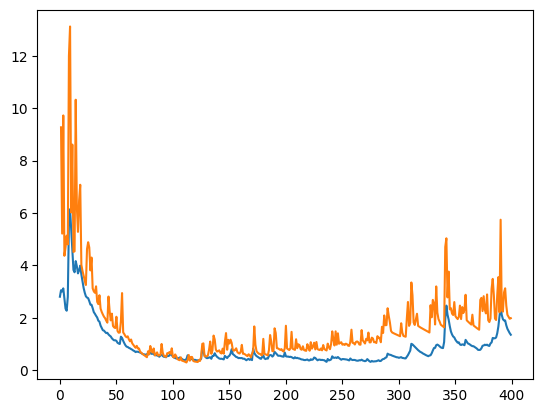

In [47]:
normalized = (data["observedRunoff"]*86400/(1018*1000))
plt.plot(normalized[:400].mean(dim=("x", "y")))
plt.plot(runoff_new[:400])
plt.show()

In [38]:
x = runoff_new["runoff"][:400].values.flatten()
y = normalized[:400].mean(dim=("x", "y")).values.flatten()

# Create a mask for non-NaN values in both arrays
mask = ~np.isnan(x) & ~np.isnan(y)

# Apply the mask and then compute Pearson correlation
r2_new = pearsonr(x[mask], y[mask])[0]
r2_new

np.float32(0.900918)

In [ ]:
class Calibrator:
    def __init__(self, initParams, rasterData, numCombi = 3, numIter = 3):
        "Rasterdata needs the layers Precipitation, Radiation, Temperature, NDVI and observedRunoff"
        self.params = initParams
        self.rasterData = self.calculate_catchment_mean(rasterData)
        self.numCombi = numCombi
        self.numIter = numIter

    def calculate_catchment_mean(self, data):
        dataMean = xr.Dataset()
        dataMean['temperature'] = data["temperature"].mean(dim=("x", "y"))
        dataMean['precipitation'] = data["precipitation"].mean(dim=("x", "y"))
        dataMean['radiation'] = data["radiation"].mean(dim=("x", "y"))
        dataMean['ndvi'] = data["ndvi"].mean(dim=("x", "y"))
        dataMean['observedRunoff'] = self.normalize_observedRunoff(data["observedRunoff"].sum(dim=("x", "y")))
        return dataMean
    
    def normalize_observedRunoff(self, observedRunoff):
        return observedRunoff*86400/(1018*1000)

    def split_data(self):
        leng = self.rasterData.sizes["time"]
        split_idx = int(leng * 0.8)

        train = self.rasterData.isel(time=slice(0, split_idx))
        test = self.rasterData.isel(time=slice(split_idx, leng))

        return train, test

    def create_paramsChoice(self, params, i):
        paramsChoice = {key: [
            value-value/(2**i),
            value, 
            value+value/(2**i)]
                for key, value in params.items()}
        return paramsChoice
   
    def calibrate_pixel(self, paramsChoice):
        # Create Params Combinations
        
        allCombinations = list(product(*paramsChoice.values()))
        randomCombinationsSample = random.sample(allCombinations, self.numCombi)
        randomCombinationsSample = [
            dict(zip(paramsChoice.keys(), combo)) for combo in randomCombinationsSample
        ]

        validation = "pearson"


        best_r = np.inf if validation == "rmse" else -np.inf
        best_params = {}
        
        #train, test = self.split_data()
        for params in randomCombinationsSample:
            wm = WaterModel(params=params, data=self.rasterData)
            runoff = wm.run_simulation_whole_catchment()
            observed = self.rasterData["observedRunoff"].values
            mask = ~np.isnan(runoff) & ~np.isnan(observed)
            if np.sum(mask) < 2:
                continue 
            if validation == "pearson":
                r, _ = pearsonr(runoff[mask], observed[mask])
                print("R: ", r)
                if r > best_r:
                    best_r = r
                    best_params = params
            # RMSE doesnt work and not worth the effort
            if validation == "rmse":
                r= np.sqrt(np.mean((observed[mask] - runoff[mask]) ** 2))
                print("RMSE: ", r)
                if r < best_r:
                    best_r = r
                    best_params = params
        return best_params, best_r
    
    def calculate_params_whole_catchment(self):
        for i in range(1,self.numIter+1):
            paramsChoice = self.create_paramsChoice(self.params, i)
            newParams, r = self.calibrate_pixel(paramsChoice)
            self.params = newParams
        newParams["R2"] = r
        return newParams
    
paramsChoice = {    
    "c_s": [210, 420, 840],
    "alpha": [2, 4, 8],
    "gamma": [0.2, 0.5, 0.8],
    "beta": [0.4, 0.6, 0.8],
    "c_m": [1, 1.5, 2],
    "temp_w": [0.25, 0.5, 0.75],
    "ndvi_w": [0.25, 0.5, 0.75],
    "iota": [2, 5, 10]
}

data = xr.Dataset()
data['temperature'] = temperature['t2m']
data['precipitation'] = precipitation['precipitation']
data['radiation'] = radiation['nr']
data['ndvi'] = ndvi['ndvi']
data['observedRunoff'] = runoffBentfeld.broadcast_like(radiation['nr'])

#get rid of anythin before 2000 and after 2022
data = data.sel(time=slice('2000-03-01', '2002-12-19'))

params_new = {
    "c_s": 840,
    "alpha": 8,
    "gamma": 0.5,
    "beta": 0.8,
    "c_m": 2.0,
    "temp_w": 0.75,
    "ndvi_w": 0.5,
    "iota": 10,
    "theta": 5
}

cal = Calibrator(initParams=params_new, rasterData=data, numCombi=10, numIter=4)
resParams = cal.calculate_params_whole_catchment()
resParams

R:  0.77711767
R:  0.7218008
R:  0.829923
R:  0.8857944
R:  0.7334272
R:  0.85682046
R:  0.8471956
R:  0.49226496
R:  0.7391493
R:  0.8609515
R:  0.85538214
R:  0.89120513
R:  0.88317215
R:  0.89391804
R:  0.87497085


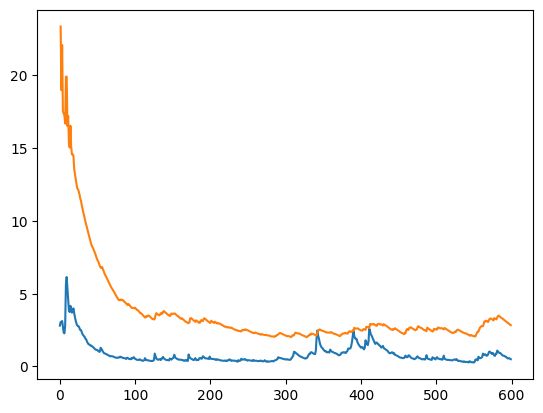

np.float32(0.5660576)

In [132]:
wm_new = WaterModel(params=resParams, data=dataMean)
runoff_new = wm_new.run_simulation_whole_catchment()
normalized = (data["observedRunoff"]*86400/(1018*1000))
plt.plot(normalized[:600].mean(dim=("x", "y")))
plt.plot(runoff_new[:600])
plt.show()

x = runoff_new
y = normalized.mean(dim=("x", "y")).values.flatten()

# Create a mask for non-NaN values in both arrays
mask = ~np.isnan(x) & ~np.isnan(y)

# Apply the mask and then compute Pearson correlation
r2_new = pearsonr(x[mask], y[mask])[0]
r2_new

In [124]:
len(runoff_new)

1024

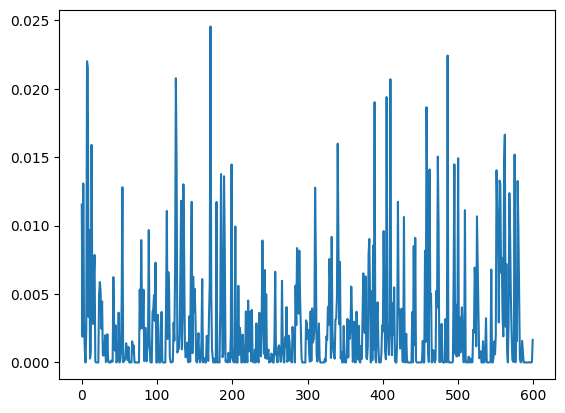

In [113]:
plt.plot(dataMean["precipitation"][:600])

In [ ]:
data_path = r"data/catchments/GRDC-Daily.nc"

runoff = xr.open_mfdataset(data_path).load()
runoff = runoff.sel(time=slice('2000-03-01', '2022-12-19'))

bentfeld_id = runoff["station_name"].values == "BENTFELD"
bentfeld_index = np.where(bentfeld_id)[0][0]

# Select only that timeseries
runoffBentfeld = runoff["runoff_mean"].isel(id=bentfeld_index)

In [6]:
bentfeld_path = r"data/bentfeld"
treia_path = r"data/catchment_timeseries/treia"
klempenow_path = r"data/catchment_timeseries/klempenow"

temperature = xr.open_mfdataset(bentfeld_path + '/temperature.nc', combine='by_coords').load()
precipitation = xr.open_mfdataset(bentfeld_path + '/precipitation.nc', combine='by_coords').load()
radiation = xr.open_mfdataset(bentfeld_path + '/radiation.nc', combine='by_coords').load()
ndvi = xr.open_mfdataset(bentfeld_path + '/ndvi.nc', combine='by_coords').load()

data = xr.Dataset()
data['temperature'] = temperature['t2m']
data['precipitation'] = precipitation['precipitation']
data['radiation'] = radiation['nr']
data['ndvi'] = ndvi['ndvi']
data['observedRunoff'] = runoffBentfeld.broadcast_like(radiation['nr'])

#get rid of anythin before 2000 and after 2022
data = data.sel(time=slice('2000-03-01', '2022-12-19'))
data

<xarray.Dataset> Size: 7MB
Dimensions:         (time: 8329, x: 5, y: 5)
Coordinates:
  * time            (time) datetime64[ns] 67kB 2000-03-01 ... 2022-12-19
  * x               (x) float64 40B 8.55 8.65 8.75 8.85 8.95
  * y               (y) float64 40B 51.85 51.75 51.65 51.55 51.45
    spatial_ref     int64 8B 0
    id              int32 4B 6335082
Data variables:
    temperature     (time, y, x) float32 833kB nan nan nan ... 276.1 nan nan
    precipitation   (time, y, x) float64 2MB nan nan nan ... 0.004961 nan nan
    radiation       (time, y, x) float64 2MB nan nan nan ... -2.438e+04 nan nan
    ndvi            (time, y, x) float64 2MB nan nan nan ... 0.6008 nan nan
    observedRunoff  (time, y, x) float32 833kB 33.08 33.08 33.08 ... nan nan nan

In [12]:
paramsChoice = {    
    "c_s": [210, 420, 840],
    "alpha": [2, 4, 8],
    "gamma": [0.2, 0.5, 0.8],
    "beta": [0.4, 0.6, 0.8],
    "c_m": [1, 1.5, 2],
    "et_weight": [(0.5, 0.25), (0.75, 0.5), (0.5, 0.5)]
}

cal = Calibrator(paramsChoice=paramsChoice, rasterData=data, amountCombinations=3)
cal.split_data()

FrozenMappingWarningOnValuesAccess({'time': 8329, 'x': 5, 'y': 5})
